# DenseNet Architecture

In [1]:
import pathlib

import tensorflow as tf
from bcd.model.factory import DenseNetFactory
from bcd.model.visual import learning_curve
from bcd.utils.model import thaw

In [2]:
batch_size = 32
input_shape = (224,224,3)
output_shape = 1

initial_epochs = 100  # Number of epochs to train for feature extraction

fine_tune_epochs = 10  # Number of epochs for each fine tune round
fine_tune_thaw_rate = 0.05  # Additional proportion of layers to unthaw each fine tune round. 

early_stop_monitor = "val_loss"  # Monitor validation loss for early stopping
early_stop_patience = 3  # The number of consecutive epochs for which lack of improvement is tolerated 
early_stop_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.

learning_rate_base = 0.0001  # Base learning rate for the Adam optimizer 
learning_rate_decay = 10 # The factor by which learning rate decays for each fine tune round.

loss = "binary_crossentropy"
activation = "sigmoid"
metric = "accuracy"

train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')
checkpoint_path = "models/checkpoints/densenet.ckpt"

## Preliminaries - Callbacks
Create a callback checkpoint that will automatically save model weights at each epoch.

In [3]:
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [4]:
# Create an early stopping callback that will stop training if validation loss doesn't improve in n epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=early_stop_monitor, patience=early_stop_patience, restore_best_weights=early_stop_restore_best_weights)

## Load Data

In [5]:
# Training DataSet (10%)
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Feature Extraction

In [6]:
factory = DenseNetFactory()
densenet_1 = factory.create(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate_base, trainable=False, loss=loss, activation=activation, metric=metric)
densenet_1_history = densenet_1.fit(train_ds_10, epochs=initial_epochs, validation_data=val_ds_10, callbacks=[checkpoint_callback, early_stop_callback])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.5520
Epoch 1: val_loss improved from inf to 0.70129, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 59s 6s/step - loss: 0.6983 - accuracy: 0.5520 - val_loss: 0.7013 - val_accuracy: 0.5818
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.5430
Epoch 2: val_loss improved from 0.70129 to 0.69118, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 43s 6s/step - loss: 0.7162 - accuracy: 0.5430 - val_loss: 0.6912 - val_accuracy: 0.5818
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.5339
Epoch 3: val_loss improved from 0.69118 to 0.67899, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 44s 6s/step - loss: 0.6729 - accuracy: 0.5339 - val_loss: 0.6790 - val_accuracy: 0.6364
Epoch 4/100
7/7 [========================

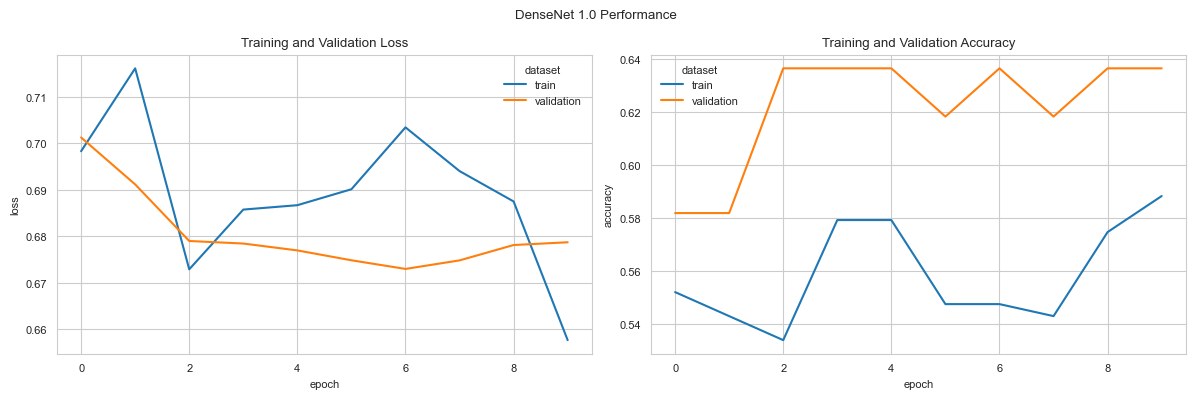

In [7]:
learning_curve(model_name='DenseNet 1.0', history=densenet_1_history)

We have an training accuracy of 60% and validation accuracy of 70% on 10% of the data in just 5 epochs. 

In [8]:
densenet_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

## Fine Tune
### Fine Tune Round 1

In [9]:
fine_tune_round = 1
densenet_1_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_round)

# Determine the number of layers to thaw.
densenet_1_base_layer = 5
densenet_1_base = densenet_1.layers[densenet_1_base_layer]
densenet_1_layers = densenet_1_base.layers
densenet_1_n_layers = len(densenet_1_layers)
thaw_n_layers = int(densenet_1_n_layers * fine_tune_thaw_rate) * fine_tune_round

# Freeze all but the top thaw_n_layers
densenet_1 = thaw(n=thaw_n_layers, model=densenet_1, base_model_layer=densenet_1_base_layer)

# Recompile the model
densenet_1.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate_base/(learning_rate_decay**fine_tune_round))), metrics=[metric])

# Check trainable weights in summary
densenet_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

In [10]:

densenet_1_history_ft_1 = densenet_1.fit(train_ds_10, epochs=densenet_1_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_1_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])

Epoch 10/110
7/7 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.5475
Epoch 10: val_loss did not improve from 0.67297
7/7 [==============================] - 60s 6s/step - loss: 0.7018 - accuracy: 0.5475 - val_loss: 0.6852 - val_accuracy: 0.5636
Epoch 11/110
7/7 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5928
Epoch 11: val_loss did not improve from 0.67297
7/7 [==============================] - 44s 6s/step - loss: 0.6888 - accuracy: 0.5928 - val_loss: 0.6781 - val_accuracy: 0.6364
Epoch 12/110
7/7 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.5158
Epoch 12: val_loss improved from 0.67297 to 0.67114, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 44s 6s/step - loss: 0.7061 - accuracy: 0.5158 - val_loss: 0.6711 - val_accuracy: 0.6000
Epoch 13/110
7/7 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.5973
Epoch 13: val_loss improved from 0.67114 to 0

### Fine Tune Round 2

In [11]:
fine_tune_round = 2
densenet_1_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_round)

# Determine the number of layers to thaw.
thaw_n_layers = thaw_n_layers * fine_tune_round

# Freeze all but the top thaw_n_layers
densenet_1 = thaw(n=thaw_n_layers, model=densenet_1, base_model_layer=densenet_1_base_layer)

# Recompile the model
densenet_1.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate_base/(learning_rate_decay**fine_tune_round))), metrics=[metric])

# Check trainable weights in summary
densenet_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

In [12]:

densenet_1_history_ft_2 = densenet_1.fit(train_ds_10, epochs=densenet_1_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_1_history_ft_1.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])

Epoch 32/120
7/7 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.6199
Epoch 32: val_loss improved from 0.64539 to 0.64479, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 62s 6s/step - loss: 0.6573 - accuracy: 0.6199 - val_loss: 0.6448 - val_accuracy: 0.6727
Epoch 33/120
7/7 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.6018
Epoch 33: val_loss did not improve from 0.64479
7/7 [==============================] - 41s 6s/step - loss: 0.6656 - accuracy: 0.6018 - val_loss: 0.6455 - val_accuracy: 0.6727
Epoch 34/120
7/7 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.6742
Epoch 34: val_loss did not improve from 0.64479
7/7 [==============================] - 39s 5s/step - loss: 0.6301 - accuracy: 0.6742 - val_loss: 0.6461 - val_accuracy: 0.6727
Epoch 35/120
7/7 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.6063
Epoch 35: val_loss did not improve from 0.644